In [501]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from scipy import stats

In [11]:
def get_film_page(film_link):
    '''
    Function takes an IMDB Pro url as a string as a parameter and returns the webpage as a Beutiful Soup object.
    Parameter:
    film_link (str): An IMDB pro url
    Returns:
    (Beautiful Soup object): the film page
    '''
    url = film_link
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page)
    return soup

In [10]:
def get_film_rating(movie_page):
    '''
    Function takes a film page Beautiful Soup object from IMDB Pro as a parameter and returns its rating
    Parameter:
    movie_page (Beautiful Soup Object): the html code of an IMDB Pro film page
    Returns:
    (float): film rating (from 0 to 10)
    '''
    return float(movie_page.find(id = 'rating_breakdown').find_all(class_ = 'a-size-medium')[-1].text[-4:-1])        

In [12]:
def get_genres(movie_page):
    '''
    Function takes a film page Beautiful Soup object from IMDB Pro as a parameter and returns its genres
    Parameter:
    movie_page (Beautiful Soup Object): the html code of an IMDB Pro film page
    Returns:
    (str): One string of the genres for that film with an added ',' to be used as a delimeter
    '''
    return movie_page.find(id = 'genres').text + ','

In [13]:
def get_actor_features(actor_id):
    '''
    Function takes an IMDB actor id as a parameter and creates a dictionary of features for that actor including:
    - "Name"
    - "Actor_id"
    - "Total Credits"
    - "First Film Year"
    - "Average Rating"
    - "Genres"
    Parameter:
    actor_id (str): the unique identifier used by IMDB for an actor, of the form '/name/nm000343/' for example
    Returns:
    movie_dict (dictionary): a dictionary with features for the given actor
    '''
    url = 'https://pro.imdb.com' + actor_id
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page)
    name = soup.find(id = 'name_heading').find('h1').text
    movie_dict = {}
    movie_dict['Name'] = name
    movie_dict['Actor_Id'] = actor_id
    movie_dict['Total Credits'] = int(re.findall(r'\d+', soup.find(id = 'past_film_filmography').find(class_ = 'additional_info').text)[0])

    oldest_film_year = soup.find(id = 'past_film_filmography').find_all(class_ = 'filmography_row')[-1].find(class_ = 'a-size-base a-color-secondary').text[-6:-2]
    
    film_one_link = soup.find(id = 'past_film_filmography').find_all(class_ = 'filmography_row')[-3].find(class_ = 'a-size-base-plus').find('a').get('href')
    film_two_link = soup.find(id = 'past_film_filmography').find_all(class_ = 'filmography_row')[-2].find(class_ = 'a-size-base-plus').find('a').get('href')
    film_three_link = soup.find(id = 'past_film_filmography').find_all(class_ = 'filmography_row')[-1].find(class_ = 'a-size-base-plus').find('a').get('href')

    movie_dict['First Film Year'] = int(oldest_film_year)
    
    film_page_1, film_page_2, film_page_3 = get_film_page(film_one_link), get_film_page(film_two_link), get_film_page(film_three_link)
    film_ratings = [get_film_rating(film_page_1), get_film_rating(film_page_2), get_film_rating(film_page_3)]

    movie_dict['Average Rating'] = np.average(film_ratings)
    movie_dict['Genres'] = get_genres(film_page_1) + ' ' + get_genres(film_page_2) + ' ' + get_genres(film_page_3)
    
    return movie_dict
    

In [15]:
#load list of actor ids
US_actors2 = pickle.load( open( "US_actor_list2.p", "rb" ) )

2285

In [17]:
US_list_scrape2 = []

In [19]:
#for loop goes through list of actors and builds a list of dictionaries
for actor_id in US_actors2:
    try: 
        US_list_scrape2.append(get_actor_features(actor_id))
    except:
        continue

In [21]:
raw_df_2 = pd.DataFrame(US_list_scrape2)

In [22]:
#pickle raw dataframe
pickle.dump(raw_df_2, open( "raw_df_2.p", "wb" ) )

In [39]:
raw_df_2

,Name,Actor_Id,Total Credits,First Film Year,Average Rating,Genres
0,Tomas Milian (1933–2017)\n,/name/nm0587401/,100,1959,7.033333,"Comedy, Drama, Drama, Crime, Drama,"
1,Sandra Bullock,/name/nm0000113/,55,1987,3.866667,"Comedy, Drama, Comedy, Action, Thriller, Adven..."
2,Adam Copeland (I),/name/nm0178581/,19,2000,6.200000,"Action, Action, Sport, Action, Adventure, Fant..."
3,Jason Alexander (I),/name/nm0004517/,70,1981,6.600000,"Comedy, Adventure, Drama, Thriller, Horror,"
4,Kim Walker (I) (1968–2001)\n,/name/nm0907947/,9,1989,6.133333,"Drama, Sci-Fi, Thriller, Comedy, Drama, Romanc..."
...,...,...,...,...,...,...
1530,Todd Bridges (I),/name/nm0004775/,70,1988,5.033333,"Drama, Comedy, Thriller, Horror,"
1531,Kerrigan Mahan,/name/nm0536748/,44,1979,7.066667,"Animation, Adventure, Sci-Fi, Animation, Actio..."
1532,Famke Janssen,/name/nm0000463/,54,1992,5.366667,"Short, Action, Adventure, Thriller, Drama, Thr..."
1533,Mark Feuerstein (I),/name/nm0275417/,26,1998,5.533333,"Comedy, Comedy, Romance, Comedy, Drama, Fantasy,"


In [40]:
raw_df_2['Genre_List'] = raw_df_2['Genres'].apply(lambda genre: list(set(genre.replace(',', '').split(' '))))

In [41]:
#this makes the list of genres into dummy columns
genre_dummies2 = raw_df_2['Genre_List'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')
added_genres2 = pd.concat([raw_df_2, genre_dummies2], axis=1)

In [519]:
#removes outliers with over 300 film credits
no_outliers = added_genres2[(added_genres2['Total Credits'] < 300) & (added_genres2['Total Credits'] > 2) ]

In [397]:
#reset index needed due to removing outliers
no_outliers.reset_index(inplace = True)
del no_outliers['index']
no_outliers

,Name,Actor_Id,Total Credits,First Film Year,Average Rating,Genres,Genre_List,Drama,Crime,Comedy,...,Family,Music,Biography,Short,History,Musical,Documentary,Mystery,Adult,Log-Diff
0,Tomas Milian (1933–2017)\n,/name/nm0587401/,100,1959,7.033333,"Comedy, Drama, Drama, Crime, Drama,","[Drama, Crime, Comedy]",1,1,1,...,0,0,0,0,0,0,0,0,0,4.110874
1,Sandra Bullock,/name/nm0000113/,55,1987,3.866667,"Comedy, Drama, Comedy, Action, Thriller, Adven...","[Adventure, Action, Thriller, Drama, Comedy]",1,0,1,...,0,0,0,0,0,0,0,0,0,3.496508
2,Adam Copeland (I),/name/nm0178581/,19,2000,6.200000,"Action, Action, Sport, Action, Adventure, Fant...","[Sport, Adventure, Fantasy, Action]",0,0,0,...,0,0,0,0,0,0,0,0,0,2.995732
3,Jason Alexander (I),/name/nm0004517/,70,1981,6.600000,"Comedy, Adventure, Drama, Thriller, Horror,","[Adventure, Horror, Thriller, Drama, Comedy]",1,0,1,...,0,0,0,0,0,0,0,0,0,3.663562
4,Kim Walker (I) (1968–2001)\n,/name/nm0907947/,9,1989,6.133333,"Drama, Sci-Fi, Thriller, Comedy, Drama, Romanc...","[Thriller, Drama, Crime, Sci-Fi, Romance, Comedy]",1,1,1,...,0,0,0,0,0,0,0,0,0,3.433987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,Todd Bridges (I),/name/nm0004775/,70,1988,5.033333,"Drama, Comedy, Thriller, Horror,","[Thriller, Drama, Horror, Comedy]",1,0,1,...,0,0,0,0,0,0,0,0,0,3.465736
1526,Kerrigan Mahan,/name/nm0536748/,44,1979,7.066667,"Animation, Adventure, Sci-Fi, Animation, Actio...","[Adventure, Action, Family, Crime, Sci-Fi, Ani...",0,1,0,...,1,0,0,0,0,0,0,0,0,3.713572
1527,Famke Janssen,/name/nm0000463/,54,1992,5.366667,"Short, Action, Adventure, Thriller, Drama, Thr...","[Adventure, Action, Short, Thriller, Drama]",1,0,0,...,0,0,0,1,0,0,0,0,0,3.332205
1528,Mark Feuerstein (I),/name/nm0275417/,26,1998,5.533333,"Comedy, Comedy, Romance, Comedy, Drama, Fantasy,","[Drama, Fantasy, Romance, Comedy]",1,0,1,...,0,0,0,0,0,0,0,0,0,3.091042


In [520]:
#creates new feature from Film Year with a more normal distribution
max_year = no_outliers['First Film Year'].max() + 1
no_outliers['Log-Diff'] = no_outliers['First Film Year'].apply(lambda year: np.log(max_year - year))

C:\Users\peter\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2001

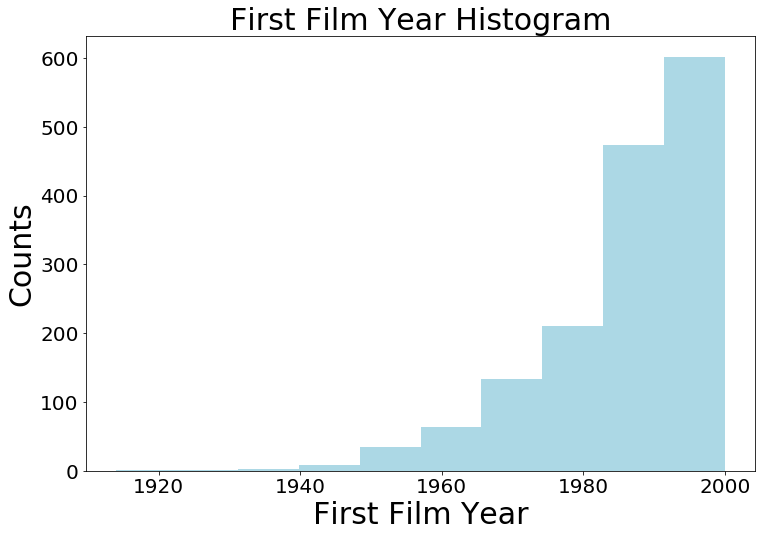

In [558]:
plt.figure(figsize=(12, 8))

plt.xlabel('First Film Year', fontsize=30)
plt.ylabel('Counts', fontsize=30);
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.title("First Film Year Histogram", fontsize = 30)

sns.distplot(no_outliers['First Film Year'],kde = False, bins = 10, color = '#309ebf')
#plt.savefig('.png')


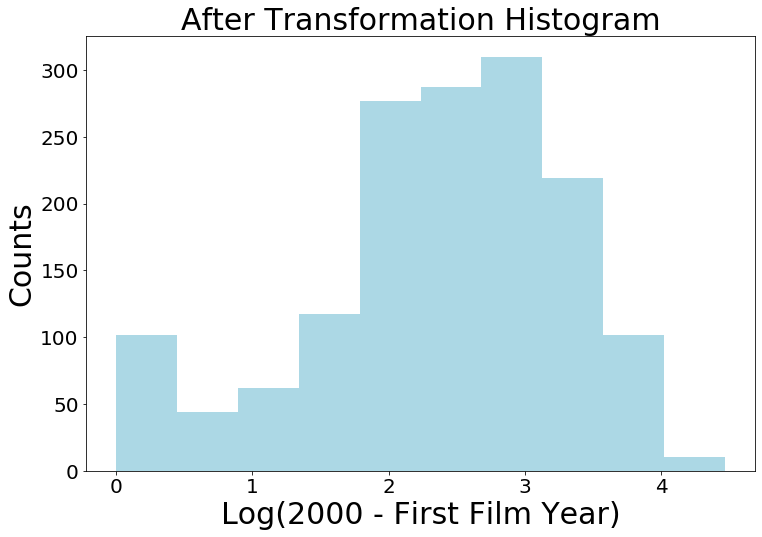

In [560]:
plt.figure(figsize=(12, 8))

plt.ylabel('Counts', fontsize=30);
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.title("After Transformation Histogram", fontsize = 30)

sns.distplot(no_outliers['Log-Diff'],kde = False, bins = 10, color = '#309ebf')
plt.xlabel('Log(2000 - First Film Year)', fontsize=30)
plt.savefig('AFhist.png')


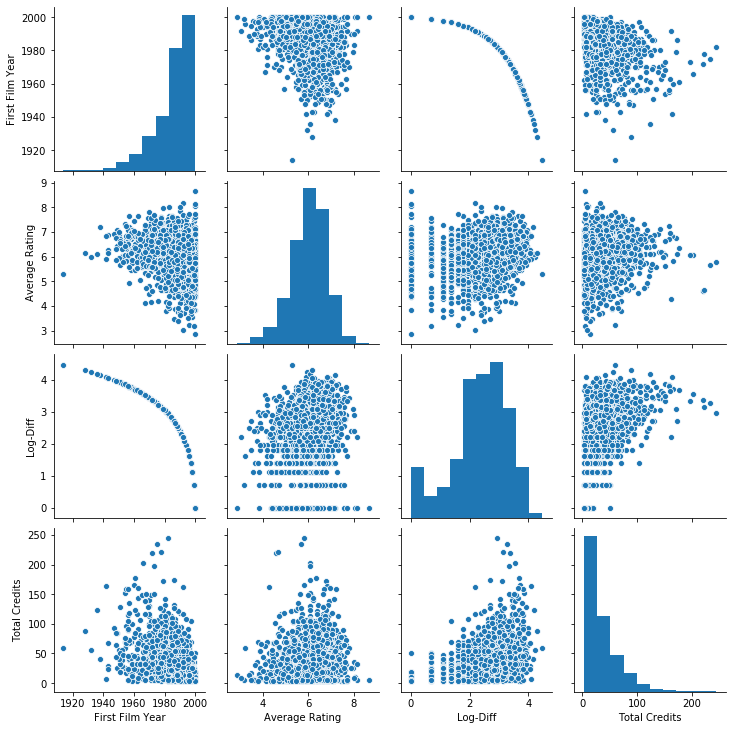

In [522]:
sns.pairplot(no_outliers[['First Film Year','Average Rating', 'Log-Diff', 'Total Credits']])

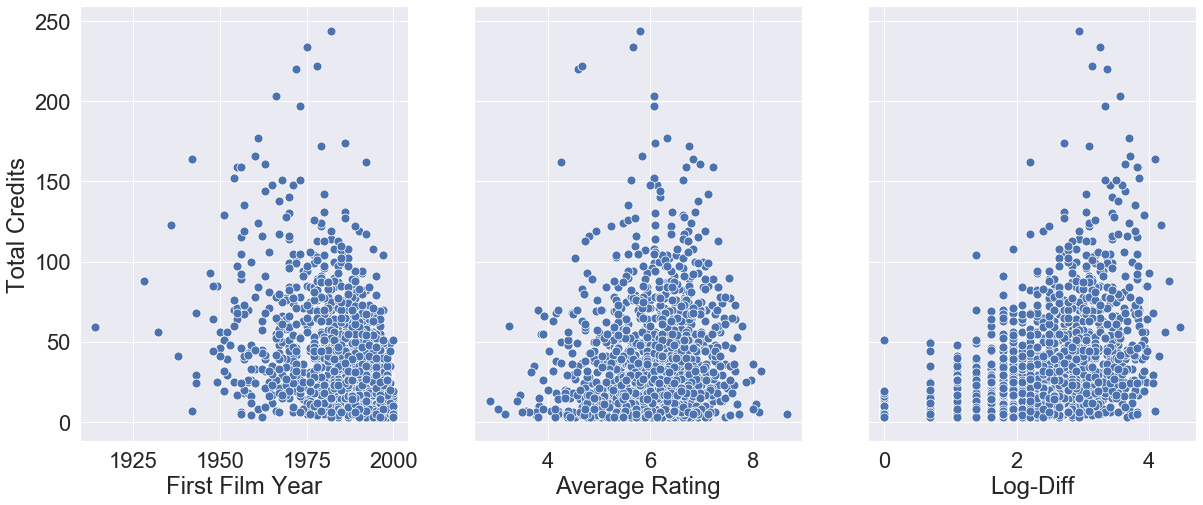

In [615]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20, 8))

sns.scatterplot(no_outliers['First Film Year'], y = no_outliers['Total Credits'], s=80, ax = ax1)

sns.scatterplot(no_outliers['Average Rating'], y = no_outliers['Total Credits'], s=80,ax = ax2)
sns.scatterplot(no_outliers['Log-Diff'], y = no_outliers['Total Credits'],s=80, ax = ax3)
plt.savefig('scatters.png')

In [465]:
no_outliers.sum()

Name               Tomas Milian (1933–2017)\nSandra BullockJason ...
Actor_Id           /name/nm0587401//name/nm0000113//name/nm000451...
Total Credits                                                  53841
First Film Year                                              2834331
Average Rating                                               8625.13
Genres             Comedy, Drama, Drama, Crime, Drama,Comedy, Dra...
Genre_List         [Drama, Crime, Comedy, Adventure, Action, Thri...
Drama                                                           1229
Crime                                                            556
Comedy                                                          1033
Adventure                                                        297
Action                                                           529
Thriller                                                         486
Sport                                                             90
Fantasy                           

In [495]:
X_train, X_test, y_train, y_test = train_test_split(no_outliers[['First Film Year',
       'Average Rating', 'Log-Diff','Drama', 'Comedy', 'Crime',
       'Action', 'Sport', 'Adventure', 'Fantasy', 'Horror', 'Thriller',
       'Romance', 'Sci-Fi', 'Western', 'War', 'Animation',
       'Family', 'Biography', 'Short', 'Musical', 'Mystery',
       'History', 'Documentary']], no_outliers['Total Credits'], test_size=0.3, random_state=2)
m = LinearRegression()
m.fit(X_train,y_train)
print("LIN REG -- Train Score: " , m.score(X_train,y_train), "   Test Score: ", m.score(X_test,y_test))

p = PolynomialFeatures(degree = 2)
X_poly_train = p.fit_transform(X_train)
X_poly_test = p.fit_transform(X_test)
lr_full = LinearRegression()
lr_full.fit(X_poly_train, y_train)

print("POLY FEAT -- Train Score: " , lr_full.score(X_poly_train, y_train), "   Test Score: ", lr_full.score(X_poly_test,y_test))
print()
m2 = LassoCV(max_iter=60000)
p2 = PolynomialFeatures(degree = 2)
X_poly_train2 = p2.fit_transform(X_train)
X_poly_test2 = p2.fit_transform(X_test)
s = StandardScaler()
X_scaled_poly_train = s.fit_transform(X_poly_train2)
X_scaled_poly_test = s.fit_transform(X_poly_test2)
m2.fit(X_scaled_poly_train, y_train)
print("LASSO (WITH POLY)-- Train Score: ", m2.score(X_scaled_poly_train, y_train), "   Test Score: ", m2.score(X_scaled_poly_test, y_test))
print()

m4 = LassoCV()
s = StandardScaler()
X_scaled_train = s.fit_transform(X_train)
X_scaled_test = s.fit_transform(X_test)
m4.fit(X_scaled_train, y_train)
print("LASSO (NO POLY)-- Train Score: ", m4.score(X_scaled_train, y_train), "   Test Score: ", m4.score(X_scaled_test, y_test))
print()

print(list(zip(X_train.columns, m4.coef_)))


LIN REG -- Train Score:  0.22844876853990903    Test Score:  0.22962607722008066
POLY FEAT -- Train Score:  0.43923421234561555    Test Score:  -0.266042579978522

LASSO -- Train Score:  0.22254342302112873    Test Score:  0.2118475412808487

LASSO (NO POLY)-- Train Score:  0.22316182283588026    Test Score:  0.22738568838838513

[('First Film Year', -4.468943892776073), ('Average Rating', 0.9020502094012394), ('Log-Diff', 9.481773329824312), ('Drama', 0.0), ('Comedy', -0.8047689764735081), ('Crime', -0.08350802187567755), ('Action', -0.0), ('Sport', 0.0), ('Adventure', 0.8045367326242876), ('Fantasy', -0.9689367681437554), ('Horror', 0.0), ('Thriller', -2.155908046820217), ('Romance', -0.0), ('Sci-Fi', -0.0), ('Western', 0.6572064351202377), ('War', -0.0), ('Animation', 1.0999970185256767), ('Family', 0.0), ('Biography', 0.0), ('Short', 0.0), ('Musical', -0.5248279857303096), ('Mystery', -0.5308037481277849), ('History', 0.0), ('Documentary', -0.857962247165669)]


In [341]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [496]:
s = StandardScaler()
X_tr_scaled = s.fit_transform(X_train)
X_te_scaled = s.fit_transform(X_test)
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_scaled, y_train)
print(list(zip(X_train.columns, lasso_model.coef_)))
print()
test_set_pred = lasso_model.predict(X_te_scaled)
print(mae(y_test, test_set_pred))
print()
print(lasso_model.score(X_scaled_train, y_train))
print()
print(r2_score(y_test, test_set_pred))

[('First Film Year', -4.461313981666479), ('Average Rating', 0.8914679102837698), ('Log-Diff', 9.471324241410406), ('Drama', 0.0), ('Comedy', -0.7872926636259014), ('Crime', -0.06394892999416799), ('Action', -0.0), ('Sport', 0.0), ('Adventure', 0.7928583238884076), ('Fantasy', -0.9483267247605897), ('Horror', 0.0), ('Thriller', -2.1409147015856362), ('Romance', -0.0), ('Sci-Fi', -0.0), ('Western', 0.6454453821056031), ('War', -0.0), ('Animation', 1.086944083172869), ('Family', 0.0), ('Biography', 0.0), ('Short', 0.0), ('Musical', -0.49908033340522046), ('Mystery', -0.5144793328848964), ('History', 0.0), ('Documentary', -0.8369999766286385)]

20.081432369391443

0.22292305109279031

0.22716755880647088


In [497]:
X_train, X_test, y_train, y_test = train_test_split(no_outliers[['First Film Year',
       'Average Rating','Log-Diff', 'Comedy',
       'Adventure', 'Fantasy', 'Thriller',
        'Animation',
        'Musical', 'Mystery',
        'Documentary']], no_outliers['Total Credits'], test_size=0.3, random_state=3)

m = LinearRegression()
m.fit(X_train,y_train)
print("LIN REG -- Train Score: " , m.score(X_train,y_train), "   Test Score: ", m.score(X_test,y_test))

p = PolynomialFeatures(degree = 2)
X_poly_train = p.fit_transform(X_train)
X_poly_test = p.fit_transform(X_test)
lr_full = LinearRegression()
lr_full.fit(X_poly_train, y_train)

print("POLY FEAT -- Train Score: " , lr_full.score(X_poly_train, y_train), "   Test Score: ", lr_full.score(X_poly_test,y_test))
print()

s = StandardScaler()
X_tr_scaled = s.fit_transform(X_train)
X_te_scaled = s.fit_transform(X_test)
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_scaled, y_train)
print(list(zip(X_train.columns, lasso_model.coef_)))
print()
test_set_pred = lasso_model.predict(X_te_scaled)
print("MAE (test): ", mae(y_test, test_set_pred))
print("MAE (training): ", mae(y_train, lasso_model.predict(X_tr_scaled)))
print()
print("Lasso with CV-- Train Score: " , lasso_model.score(X_tr_scaled, y_train), "   Test Score: ", lasso_model.score(X_te_scaled, y_test))



LIN REG -- Train Score:  0.22590460466091664    Test Score:  0.23589215833603872
POLY FEAT -- Train Score:  0.27393830061673097    Test Score:  0.17166192301112182

[('First Film Year', -4.693880095186677), ('Average Rating', 0.7394857453430429), ('Log-Diff', 9.839458097012246), ('Comedy', -2.6862817735421554), ('Adventure', 0.9146917880163583), ('Fantasy', -2.061226742118301), ('Thriller', -2.8962401424572835), ('Animation', 0.9655963335671998), ('Musical', -1.4020211013885815), ('Mystery', -1.577817845530758), ('Documentary', -1.0352645490372494)]

19.83790675055666
Lasso with CV-- Train Score:  0.22561798019000212    Test Score:  0.23874809396055616


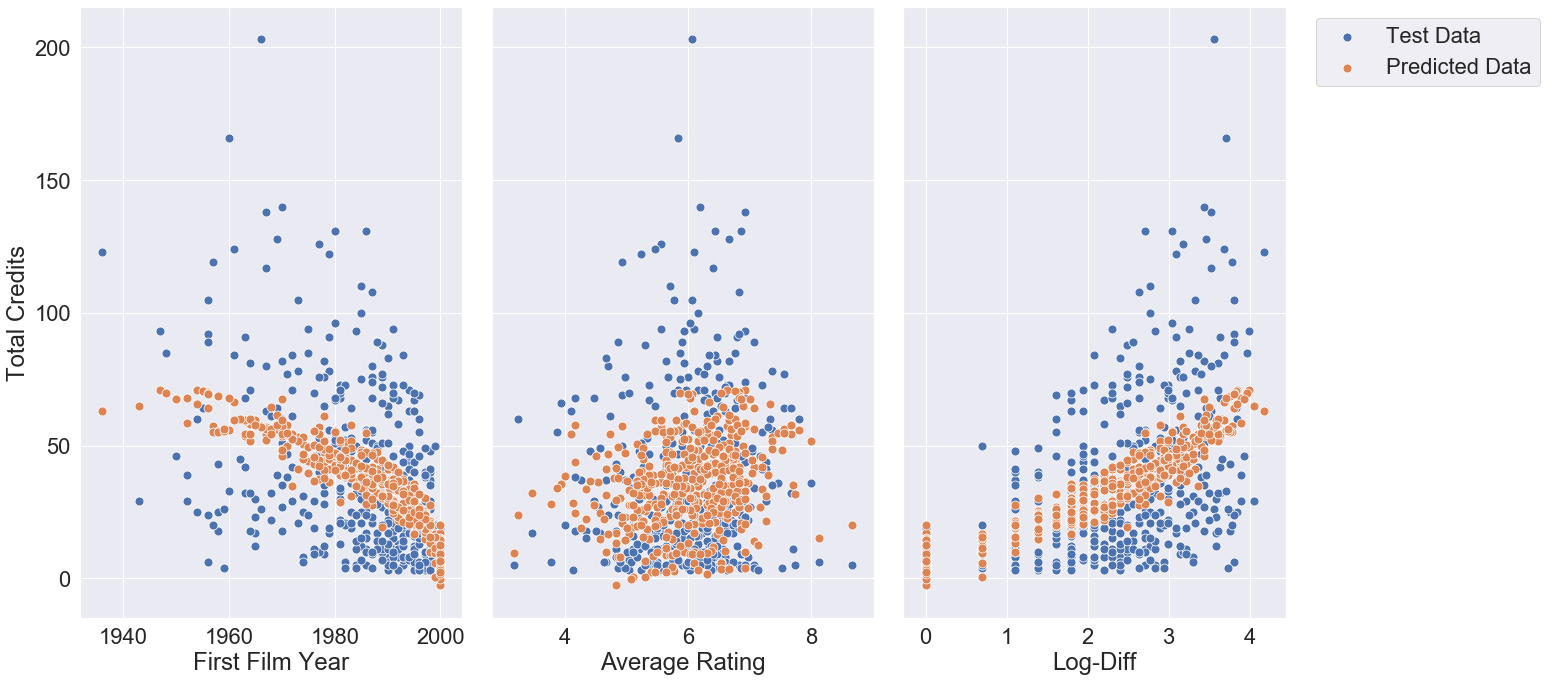

In [644]:

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(22, 10))
sns.scatterplot(X_test['First Film Year'], y_test, s=80, ax = ax1)
sns.scatterplot(X_test['First Film Year'], test_set_pred, s=80, ax = ax1)

sns.scatterplot(X_test['Average Rating'], y_test, s=80, ax = ax2)
sns.scatterplot(X_test['Average Rating'], test_set_pred, s=80, ax = ax2)

sns.scatterplot(X_test['Log-Diff'], y_test, s=80, ax = ax3)
sns.scatterplot(X_test['Log-Diff'], test_set_pred, s=80, ax = ax3)

plt.legend(labels=['Model Test Data', 'Model Predicted Data'], bbox_to_anchor=(1.05, 1))
plt.tight_layout()

plt.savefig('new_scatters.png')


In [ ]:
residuals = (lasso_model.predict(X_te_scaled) - y_test)

plt.figure(figsize=(12, 8))
sns.scatterplot(y_test, residuals, alpha = .8, s=80 )    #change this if working with sklearn
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Credits', fontsize=30)
plt.ylabel('Residuals', fontsize=30);
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.title("Plot of Residuals vs. Predicted Credits for \n Actors with Under 300 Total Credits", fontsize = 30)

skewed_resids = residuals[residuals < -40]


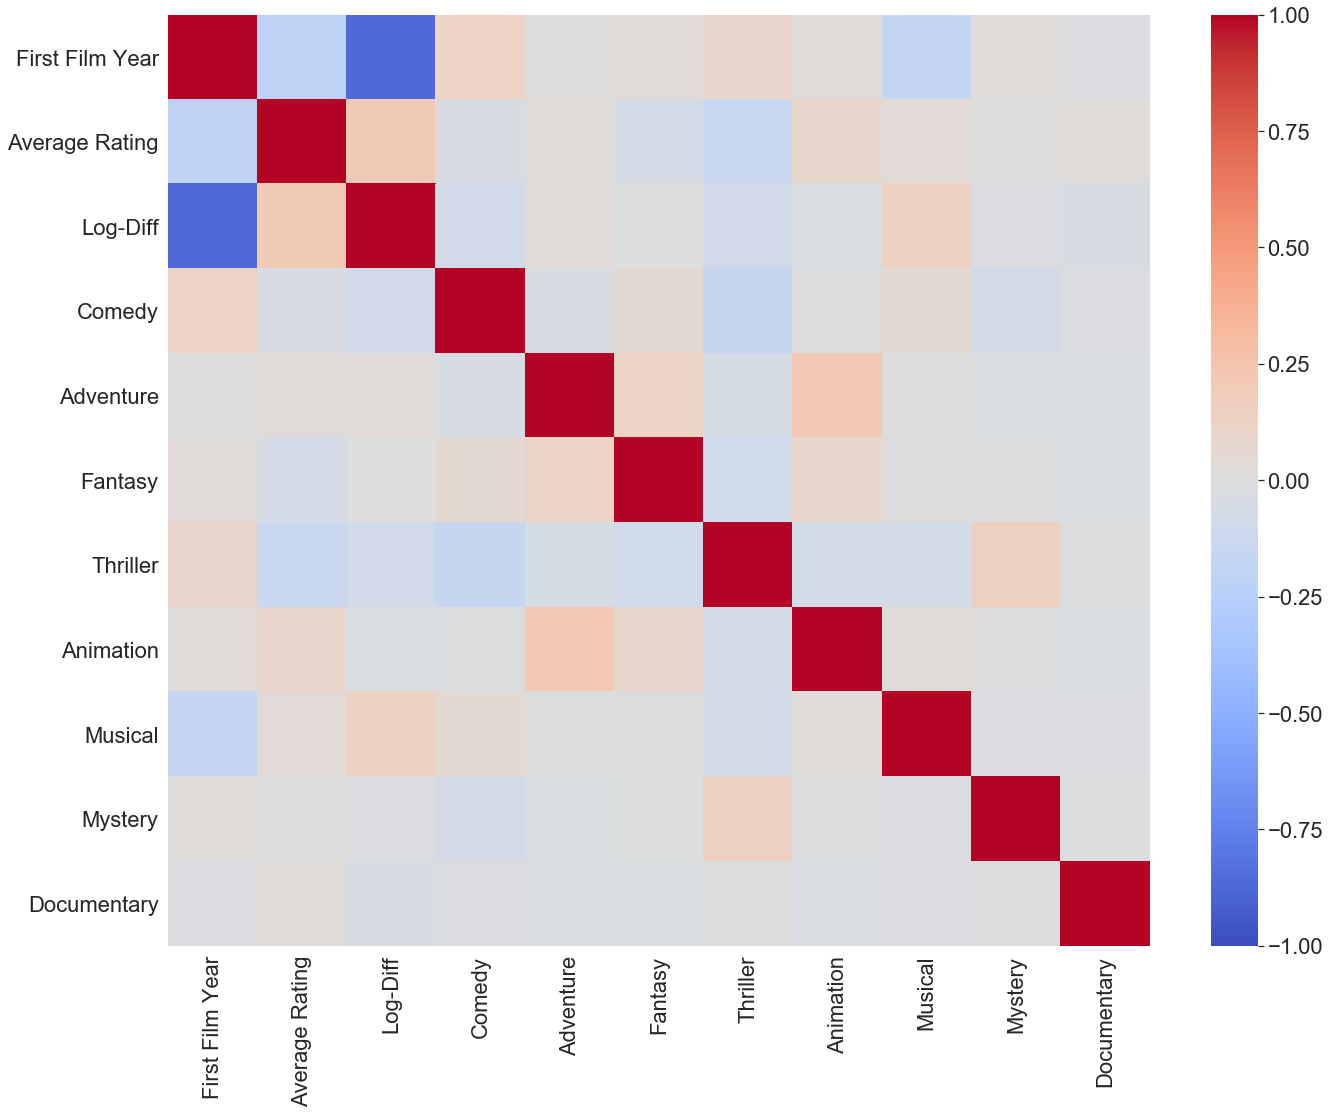

In [621]:
plt.figure(figsize=(20,16))
sns.heatmap(no_outliers[['First Film Year',
       'Average Rating','Log-Diff', 'Comedy',
       'Adventure', 'Fantasy', 'Thriller',
        'Animation',
        'Musical', 'Mystery',
        'Documentary']].corr(), cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.tight_layout()

plt.savefig('heatmap.png')


In [ ]:
'''
TO TRY:

I saw something where if your residuals have a strong pattern with your predicted values, 
you can fit a line to the residuals vs the predicted value and use it adjust the predicted values! 
I haven’t tried it
'''